# openWithHaloFinder.ipynb

This is an advanced tutorial using FIREreader, be warned!!

This notebook is best used on Stampede2, where the halo file and snapshot directories live. You can run this notebook, and host a Firefly server, on Stampede by following the instructions [here](https://github.com/ageller/Firefly/wiki/Hosting-Firefly-on-a-Cluster-Environment). 

In this notebook, we open the AHF halo files saved on Stampede and offset the snapshot coordinates, as well as convert them to physical units, to put the center of the main halo at our origin. This is optional, since you can always fly within Firefly to a point and set that as your origin, but more convenient (and exact!). 

We also calculate the radius from the halo center for each particle and update the filter keys so we can interactively filter by radius from within Firefly. 

#### Importantly, we do **not** call the `reader.run()` method, which would not give us the flexibility required to change our units/calculate the radii & temperature before we output to JSON. 



In [1]:
%load_ext autoreload
%autoreload 2

from FIREreader import FIREreader
from snapshot_utils import openSnapshot
from snapshot_utils import getTemperature
import numpy as np
import os
import h5py

In [2]:
## initialize reader object and choose simulation to run
reader = FIREreader()
reader.directory = r"\Users\shife\OneDrive\CIERA_REU\Snapshots\AlexRichingsCHIMES\output"
reader.snapnum = 500
## could read this from snapshot times
current_redshift=0
reader.writeStartup = False

## Setup the reader configuration and load data

In [3]:
## decide which part types to save to JSON
reader.returnParts = ['PartType0', 'PartType4']

## choose the names the particle types will get in the UI
reader.names = {'PartType0':'Gas', 
                  'PartType4':'Stars' }

In [4]:
#define the defaults; this must be run first if you want to change the defaults below
reader.defineDefaults()

## by what factor should you sub-sample the data (e.g. array[::decimate])
decimate = [1., 1.]

In [5]:
## load in the data from hdf5 files and put it into reader.partsDict
for i,p in enumerate(reader.returnParts):
    reader.decimate[p] = decimate[i]
    reader.returnKeys[p] = ['Coordinates', 'Density', 'Velocities', 'HIIAbundance', 'Temperature', 'AgeGyr']
    #Note: you should only try to filter on scalar values (like density).  
    #The magnitude of the Velocities are calculated in Firefly, and you will automatically be allowed to filter on it
    reader.addFilter[p] = [False, True, False, True, True, True]
    ## tell it to do the log of density when filtering
    reader.dolog[p] = [False, True, False, False, True, False]
    
    
    #NOTE: all dictionaries in the "options" reference the swapped names (i.e., reader.names) you define above.  
    #If you don't define reader.names, then you can use the default keys from the hdf5 files 
    #(but then you will see those hdf5 names in the Firefly GUI)
    pp = reader.names[p]
    ## set the initial size of the particles when the interface loads
    reader.options['sizeMult'][pp] = 0.15
    
## set the default colors when the interface loads
reader.options['color'] = {'Gas':  [1., 0.3, 0., 1.],  
                           'Stars':[0., 1., .85, 1]} 

## set the camera center to be at the origin (defaults to np.mean(Coordinates) otherwise)
##     later on we subtract out halo_center from coordinates but could instead make this halo_center
reader.options['center'] = np.array([0., 0., 0.])

## initialize filter flags and options
reader.defineFilterKeys()

## load in return keys from snapshot
filenames_opened = reader.populate_dict()

\Users\shife\OneDrive\CIERA_REU\Snapshots\AlexRichingsCHIMES\output\snapshot_500.hdf5
PartType0 has no AgeGyr
\Users\shife\OneDrive\CIERA_REU\Snapshots\AlexRichingsCHIMES\output\snapshot_500.hdf5
PartType4 has no Density
PartType4 has no HIIAbundance
PartType4 has no Temperature


### Let's calculate the galactocentric radius, offset the coordinates by it while we're at it, then add the array to Firefly using the `addtodict` method

In [6]:
hubble=.702

## calculate the radius from the halo center
gas_radii = np.sum(reader.partsDict['PartType0']['Coordinates']**2,axis=1)**0.5
star_radii = np.sum(reader.partsDict['PartType4']['Coordinates']**2,axis=1)**0.5

## add new radius array to the dictionary using addtodict method
reader.addtodict(reader.partsDict,None,'PartType0','Radius',0,0,vals=gas_radii, filterFlag = True)
reader.addtodict(reader.partsDict,None,'PartType4','Radius',0,0,vals=star_radii, filterFlag = True)

### Let's convert the density to physical units

In [7]:
print(reader.partsDict.keys())
print(reader.partsDict['PartType0'].keys())

dict_keys(['PartType0', 'PartType4'])
dict_keys(['Coordinates', 'log10Density', 'Velocities', 'HIIAbundance', 'log10Temperature', 'filterKeys', 'doSPHrad', 'Radius'])


In [8]:
# Code mass -> g , (code length)^-3 -> cm^-3 , g -> nHydrogen
DENSITYFACT=2e43*(3.086e21)**-3/(1.67e-24)
reader.partsDict['PartType0']['log10Density'] = reader.partsDict['PartType0']['log10Density']+np.log10(DENSITYFACT)

In [9]:
help(reader.addtodict)

Help on method addtodict in module FIREreader:

addtodict(d, snap, part, dkey, sendlog, sendmag, usekey=None, mfac=1.0, vals=None, filterFlag=False) method of FIREreader.FIREreader instance
    #adds an array to the dict for a given particle set and data file



### And now let's pre-filter certain parameters to our liking

In [10]:
# filter out stars older than 0.5 Gyr
stars_ind = np.where(reader.partsDict['PartType4']['AgeGyr'] < 0.5)[0]

# adjust appropriate dictionary keys accordingly (i.e. density, velocity, radius, temperature, stellar age)
for x in list(reader.partsDict['PartType4'].keys()):
    print(x)
    if (x not in reader.nodecimate):
        print("filtered")
        reader.partsDict['PartType4'][x] = reader.partsDict['PartType4'][x][stars_ind]

Coordinates
filtered
Velocities
filtered
AgeGyr
filtered
filterKeys
doSPHrad
Radius
filtered


In [11]:
# # filter out gas less dense than 1 particle/cm^3
# gas_ind = np.where(reader.partsDict['PartType0']['log10Density'] > -1)[0]

# # adjust appropriate dictionary keys accordingly (i.e. density, velocity, radius, temperature, stellar age)
# for x in list(reader.partsDict['PartType0'].keys()):
#     print(x)
#     if (x not in reader.nodecimate):
#         print("filtered")
#         reader.partsDict['PartType0'][x] = reader.partsDict['PartType0'][x][gas_ind]

<IPython.core.display.Javascript object>


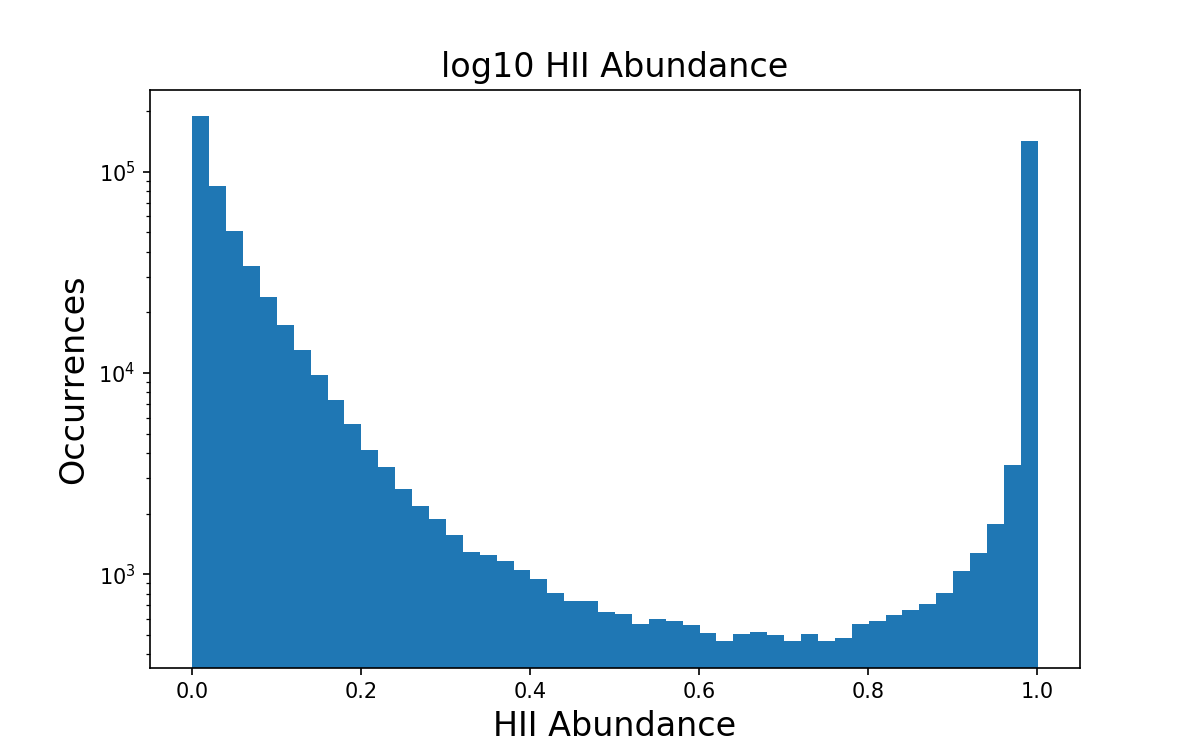

<IPython.core.display.Javascript object>


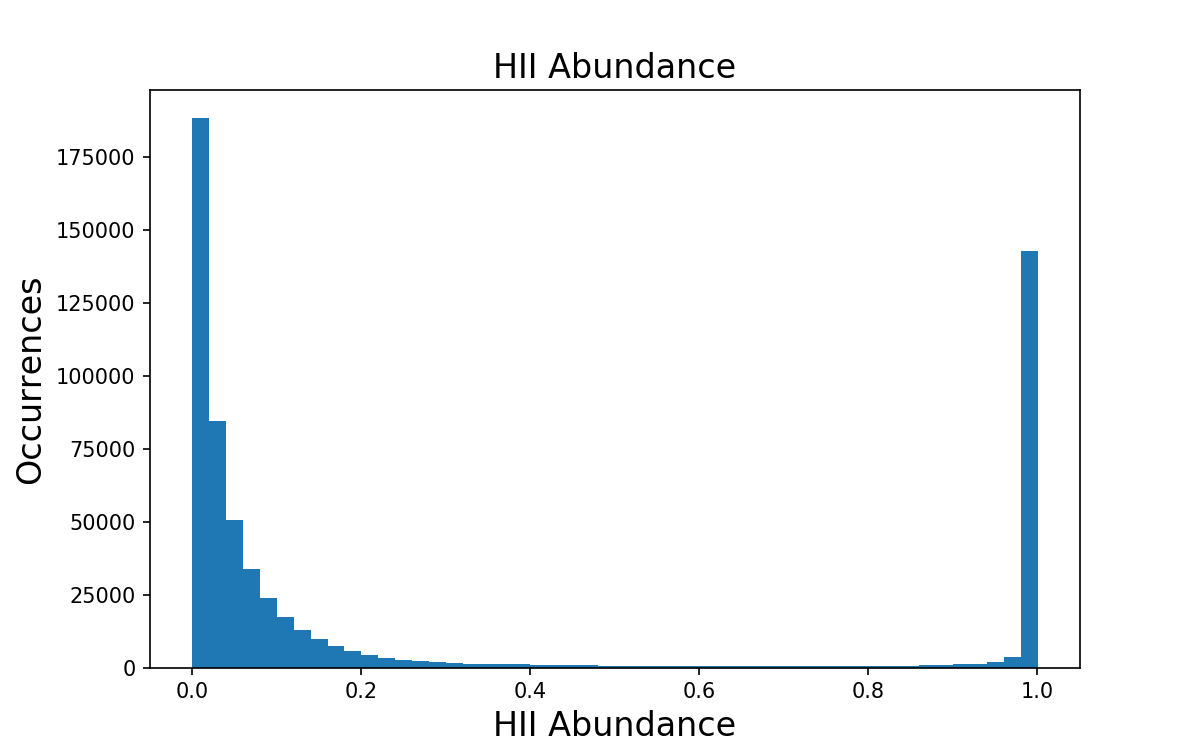

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt

f,ax = plt.subplots(figsize=(8,5))
h, b, im = ax.hist(reader.partsDict['PartType0']['HIIAbundance'], bins = 50, log = True)
ax.set_xlabel("HII Abundance", fontsize = 16)
ax.set_ylabel("Occurrences", fontsize = 16)
ax.set_title("log10 HII Abundance", fontsize = 16)
plt.savefig(filename = "log10 HII Abundance")

f,ax = plt.subplots(figsize=(8,5))
h, b, im = ax.hist(reader.partsDict['PartType0']['HIIAbundance'], bins = 50)
ax.set_xlabel("HII Abundance", fontsize = 16)
ax.set_ylabel("Occurrences", fontsize = 16)
ax.set_title("HII Abundance", fontsize = 16)
plt.savefig(filename = "HII Abundance")

In [13]:
# filter out gas less than 80% HII and more than 20% HII
HII_ind = np.where(reader.partsDict['PartType0']["HIIAbundance"] > 0.8)[0]
HII_ind_2 = np.where(reader.partsDict['PartType0']["HIIAbundance"] < 0.2)[0]
ind = np.append(HII_ind, HII_ind_2)

# adjust appropriate dictionary keys accordingly (i.e. density, velocity, radius, temperature, stellar age)
for x in list(reader.partsDict['PartType0'].keys()):
    print(x)
    if (x not in reader.nodecimate):
        print("filtered")
        reader.partsDict['PartType0'][x] = reader.partsDict['PartType0'][x][ind]

Coordinates
filtered
log10Density
filtered
Velocities
filtered
HIIAbundance
filtered
log10Temperature
filtered
filterKeys
doSPHrad
Radius
filtered


<IPython.core.display.Javascript object>


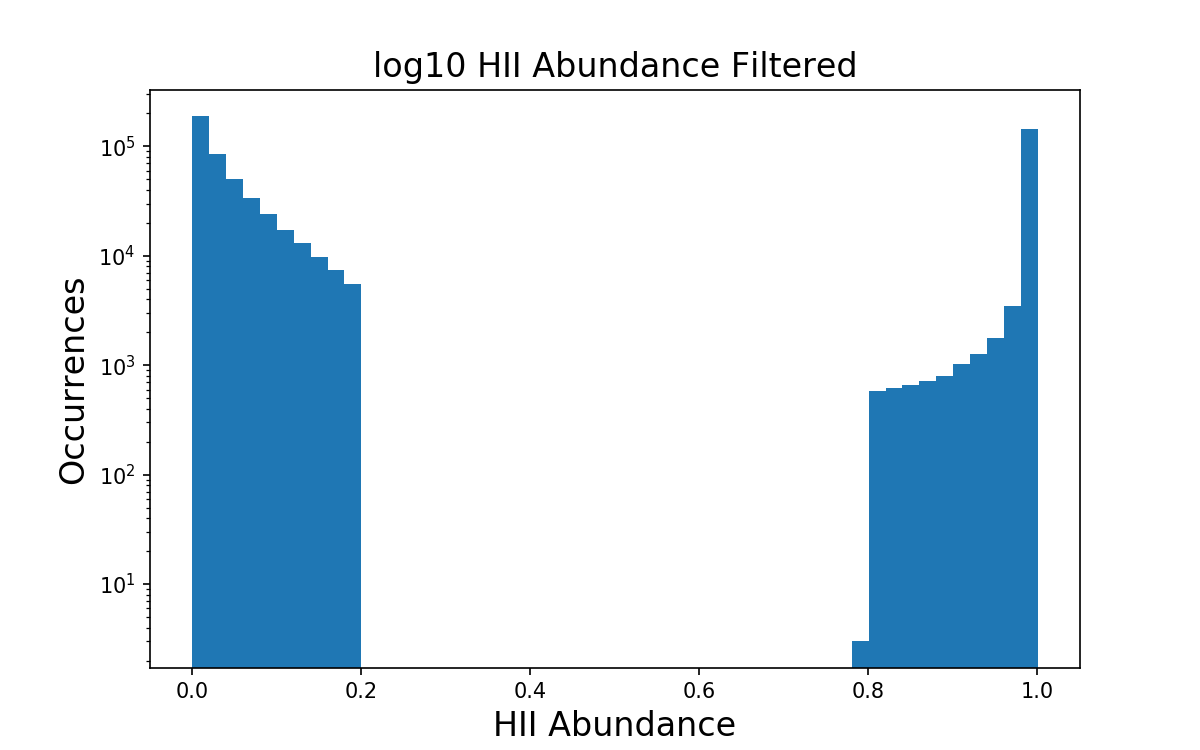

In [14]:
f,ax = plt.subplots(figsize=(8,5))
h, b, im = ax.hist(reader.partsDict['PartType0']['HIIAbundance'], bins = 50, log = True)
ax.set_xlabel("HII Abundance", fontsize = 16)
ax.set_ylabel("Occurrences", fontsize = 16)
ax.set_title("log10 HII Abundance Filtered", fontsize = 16)
plt.savefig(filename = "log10 HII Abundance Filtered")

In [15]:
reader.dataDir = "AlexRichingsCHIMES_500"

In [16]:
## finish up, let's shuffle + decimate, add the GUI friendly names, and create our final JSON!
reader.shuffle_dict()
reader.swap_dict_names()
reader.createJSON()

shuffling ... 
shuffling ... 
dataDir AlexRichingsCHIMES_500
writing JSON files ...
Gas
Stars
AlexRichingsCHIMES_500\FIREdataOptions.json
